<a href="https://colab.research.google.com/github/Bangkit-C22-PS353-Capstone-Project/Bangkit-C22-PS353-MachineLearning/blob/main/Saved_Model_of_Price_Forecasting_ML_Model_with_CNN_RNN_DNN_(Produsen_2019_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install tensorflow, Import that smooth library

In [1]:
# import that smooth library

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import csv

# Download the Data

In [2]:
# prepare the dataset, 
# download data from google drive
# https://drive.google.com/file/d/1VvkJVlgjoLPtMujqxf0Edvd5L11SpqP8/view?usp=sharing

!gdown --id 1VvkJVlgjoLPtMujqxf0Edvd5L11SpqP8

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VvkJVlgjoLPtMujqxf0Edvd5L11SpqP8
To: /content/Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (3).csv
100% 17.1k/17.1k [00:00<00:00, 19.6MB/s]


# Preprocess the data

In [3]:
# read the dataset and convert into csv
dataset = pd.read_csv('Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (3).csv')
# show me that csv
print(dataset)

     Unnamed: 0        Date  Price
0             0  2019-03-01   8.80
1             1  2019-03-04   8.80
2             2  2019-03-05   8.90
3             3  2019-03-06   8.90
4             4  2019-03-08   8.90
..          ...         ...    ...
778         778  2022-04-29   8.30
779         779  2022-05-04   8.30
780         780  2022-05-05   8.35
781         781  2022-05-06   8.30
782         782  2022-05-09   8.55

[783 rows x 3 columns]


In [4]:
# checking the datatypes
print(dataset.dtypes)

Unnamed: 0      int64
Date           object
Price         float64
dtype: object


# Visualize the Dataset

In [5]:
# put x and y axis respectively
fig = px.line(dataset, x='Date', y='Price')

# this code is to add the range slider so we can see better
fig.update_xaxes(rangeslider_visible=True)

# for showing the plot
fig.show()

# Setting up the plot function for plotting

In [6]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Preview the Dataset

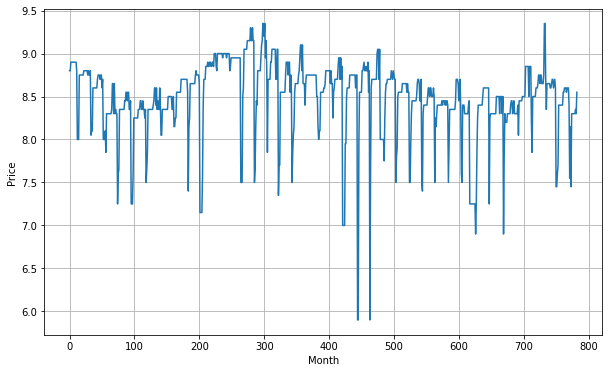

In [7]:
# Initialize lists
time_step = []
price = []

# Open CSV file
with open('./Beras Kualitas Bawah II (kg) 2019-2022.xlsx - Final (3).csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    price.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(price)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Price')

In [8]:
print(type(time))
print(type(series))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Split the Dataset

In [9]:
# Define the split time
split_time = 650

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

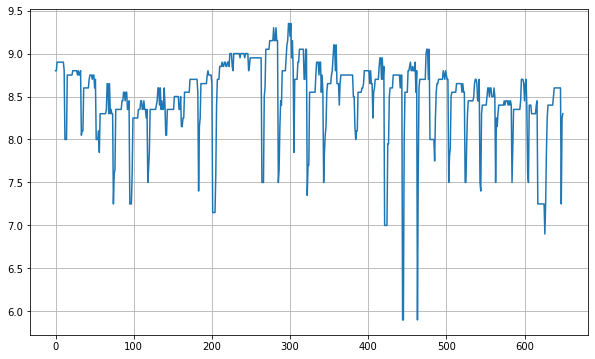

In [10]:
# Plot the train set
plot_series(time_train, x_train)

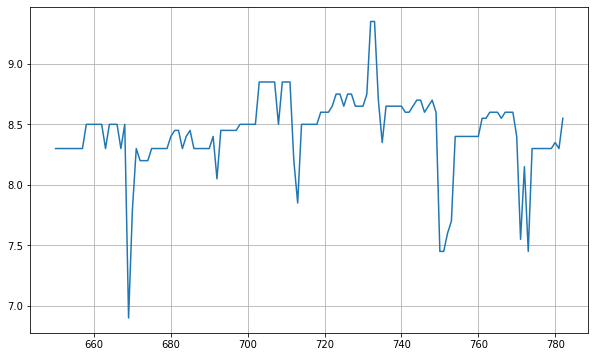

In [11]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Prepare Features and Labels

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [13]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model
You've seen these layers before and here is how it's looks like when combined.

In [14]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [15]:
# Get initial weights
init_weights = model.get_weights()

In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 17s 28ms/step - loss: 74.1005 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 69.5926 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 63.6985 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 56.9793 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 49.5034 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 41.6086 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 35.7335 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 30.3552 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 24.3490 - lr: 2.5119e-08
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 17.6073 - lr: 2.8184e-08
Epoch 11/100
20/2

(1e-08, 0.001, 0.0, 100.0)

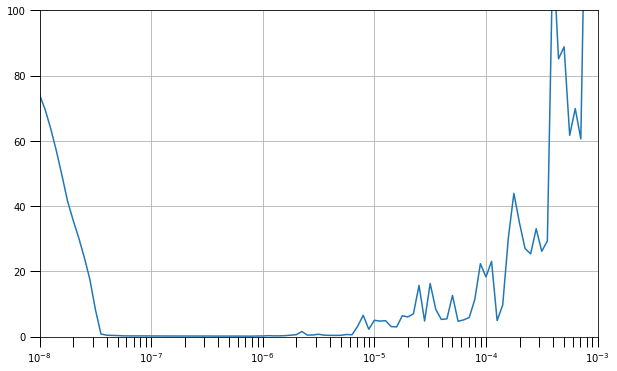

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Now let’s compile and train the model

In [18]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [19]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [20]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
20/20 [==============================] - 3s 9ms/step - loss: 29.3057 - mae: 29.7958
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.8932 - mae: 2.3550
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4621 - mae: 0.8450
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1947 - mae: 0.4865
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1563 - mae: 0.4221
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1711 - mae: 0.4452
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1727 - mae: 0.4568
Epoch 8/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1573 - mae: 0.4233
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1536 - mae: 0.4109
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1565 - mae: 0.4158
Epoch 11/100
20/20 [==============================] - 0s 

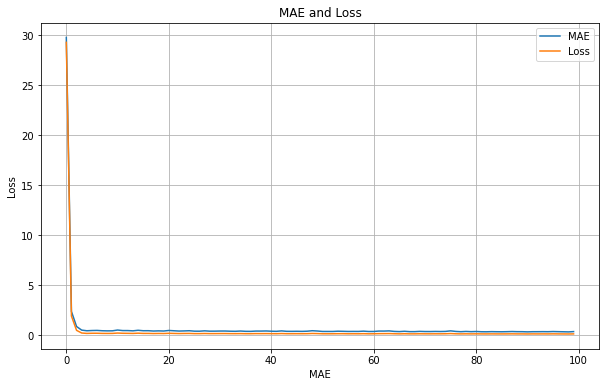

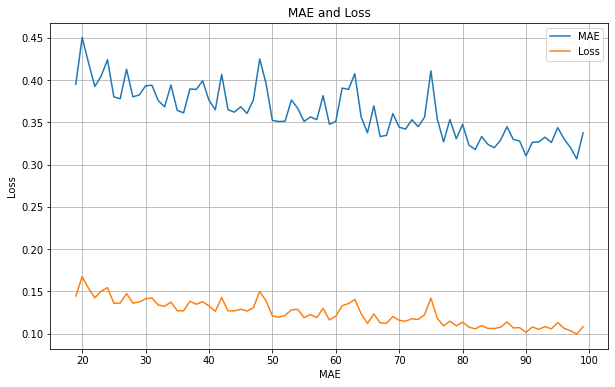

In [21]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [22]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

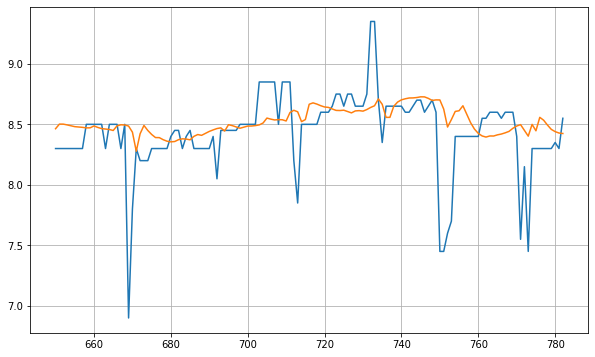

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [24]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.19278318


In [25]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
20/20 [==============================] - 4s 9ms/step - loss: 0.0983 - mae: 0.3045
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.1000 - mae: 0.3097
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0985 - mae: 0.3024
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0996 - mae: 0.3066
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0988 - mae: 0.3030
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0984 - mae: 0.3023
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0985 - mae: 0.3068
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0985 - mae: 0.3077
Epoch 9/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0997 - mae: 0.3143
Epoch 10/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1032 - mae: 0.3156


In [26]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
20/20 [==============================] - 3s 9ms/step - loss: 0.0983 - mae: 0.3072
Epoch 2/40
20/20 [==============================] - 0s 8ms/step - loss: 0.0990 - mae: 0.3032
Epoch 3/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0982 - mae: 0.3027
Epoch 4/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0994 - mae: 0.3075
Epoch 5/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0974 - mae: 0.3025
Epoch 6/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0984 - mae: 0.3021
Epoch 7/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0979 - mae: 0.3039
Epoch 8/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0982 - mae: 0.3033
Epoch 9/40
20/20 [==============================] - 0s 8ms/step - loss: 0.0982 - mae: 0.3033
Epoch 10/40
20/20 [==============================] - 0s 8ms/step - loss: 0.0975 - mae: 0.3029
Epoch 11/40
20/20 [==============================] - 0s 7ms/step - lo

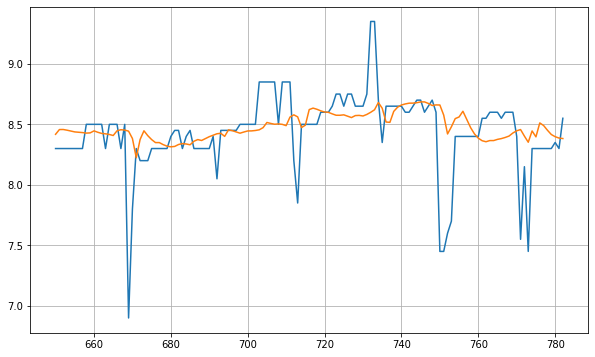

In [27]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [28]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.18602706

# Save model

In [29]:
# save model to h5 format
model.save("model.h5")

In [32]:
# convert the model
modelh5 = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(modelh5)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# save the model
with open('model_forecasting.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model_forecasting.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp4k5jtyq3/assets


INFO:tensorflow:Assets written to: /tmp/tmp4k5jtyq3/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !wget https://github.com/oleksandr-g-rock/How_to_create-image-classification-for-recognizing-persons-animals-others/raw/main/animall_person_other_v2_fine_tuned.h5

# import tensorflow as tf

# model = tf.keras.models.load_model('/content/animall_person_other_v2_fine_tuned.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("animall_person_other_v2_fine_tuned.tflite", "wb").write(tflite_model)